<a href="https://colab.research.google.com/github/raissamiranda/Computational-statistical-physics/blob/main/Ising2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulação do modelo de Ising 2D

Gabriela Moraes Miserani de Freitas - 2020006566

Isabella VIgnoli Gonçalves - 2020006655

Maria Luiza Leão - 2020100953

Raissa Miranda Maciel - 2020006965

Para explorar as propriedades termondinâmicas do Modelo Ising 2D serão realizadas simulações com o algoritmo implementado anteriormente. Com a escolha de valores para os parâmetros (tamanho do sistema, temperatura de simulação, número de passos de Monte Carlo para termalização e para calcular média termodinâmica) os resultados encontrados serão analisados.

## Modelo de Ising 2D

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

In [2]:
# Variáveis globais
n_caixas = 10
m = 10000
N = 100000

### Funções para Simulação de Monte Carlo

In [3]:
def init_spin(L):
    s = []
    for i in range(L*L):
        s.append(2*np.random.randint(2)-1)
    return s

In [4]:
def ising(L):
    N = L * L
    viz = {}
    for k in range(N):
        viz[k] = {}

        viz[k][0] = k + 1
        if ((k + 1) % L == 0):
            viz[k][0] = k + 1 - L

        viz[k][1] = k + L
        if (k > N - 1 - L ):
            viz[k][1] = k + L - N

        viz[k][2] = k - 1
        if (k%L == 0):
            viz[k][2] = k + L - 1
        
        viz[k][3] = k - L
        if (k < L):
            viz[k][3] = k + N - L

    return viz

In [5]:
def energy(viz, s, L):
    E = 0
    N = L*L
    for i in range(N):
        h = s[viz[i][0]] + s[viz[i][1]]
        E = E - (s[i] * h)
    return E

In [6]:

def magnetism(s):
    return np.sum(s)

In [7]:

def expos(beta):
    ex = np.zeros(5,dtype=np.float32)
    ex[0]=np.exp(8.0*beta)
    ex[1]=np.exp(4.0*beta)
    ex[2]=0.0
    ex[3]=np.exp(-4.0*beta)
    ex[4]=np.exp(-8.0*beta)
    return ex

In [8]:
def mcstep(beta,s,viz,ener,mag):
    N=len(s)
    ex=expos(beta)
    for i in range(N):
        h = s[viz[i][0]]+s[viz[i][1]]+s[viz[i][2]]+s[viz[i][3]] # soma dos vizinhos
        de = int(s[i]*h*0.5+2)
        if np.random.random() < ex[de]:
            ener=ener+2*s[i]*h
            mag -= 2*s[i]
            s[i]=-s[i]
    return ener,mag,s

## Funções Auxiliares

In [9]:
# calculando a média de energia descartando os m primeiros passos (até estabilizar)
def energia_i(energia, i):
    inicio = i*m
    fim = (i+1)*m
    return np.mean(energia[inicio:fim])

In [10]:
# calculando a média de magnetismo descartando os m primeiros passos (até estabilizar)
def magnetismo_i(magnetismos, i):
    inicio = i*m
    fim = (i+1)*m
    return np.mean(magnetismos[inicio:fim])

In [11]:
# calcula a média de energia ao quadrado descartando os m primeiros passos (até estabilizar)
def energia_quadrado_i(energia,i):
    inicio = i*m
    fim = (i+1)*m
    return np.mean(np.array(energia[inicio:fim])**2)

In [12]:
# calcula a média de magnetismo ao quadrado descartando os m primeiros passos (até estabilizar)
def magnetismo_quadrado_i(magnetismos, i):
    inicio = i*m
    fim = (i+1)*m
    return np.mean(np.array(magnetismos[inicio:fim])**2)

In [13]:
def calor_especifico(beta, N, energia, i):
    return (((beta**2)/N)*(energia_quadrado_i(energia,i) - (energia_i(energia,i)**2)))

In [14]:
def susceptibilidade_magnetica(beta, N, magnetismos, i):
    return ((beta/N)*( magnetismo_quadrado_i(magnetismos,i) - (magnetismo_i(magnetismos, i))**2))

In [15]:
def erro_energia(energia_mean, lista_energias_i, n):
    return np.sqrt(np.sum(np.array([(energia_mean-lista_energias_i[i]) **2 for i in range(n)]))/(n*(n-1)))

In [16]:
def erro_magnetismo(magnetismo_mean, lista_magnetismos_i, n):
        return np.sqrt(np.sum(np.array([(magnetismo_mean-lista_magnetismos_i[i])**2 for i in range(n)]))/(n*(n-1)))

In [17]:
def erro_calor_especifico(cv_mean, lista_cv_i, beta, n):
    return np.sqrt(np.sum(np.array([(cv_mean-lista_cv_i[i])**2 for i in range(n)]))/(n*(n-1)))

In [18]:
def erro_susceptibilidade(x_mean, beta, lista_xi, n):
    return np.sqrt(np.sum(np.array([(x_mean-lista_xi[i])** 2 for i in range(n)]))/(n*(n-1)))

In [19]:
def simulacao(L, temp, s):
  beta = 1/temp
  viz = ising(L)
  energia = energy(viz, s, L)
  magnetismo = magnetism(s)

  energia_lista = []
  magnetismo_lista = []
  cv_lista = []
  suscep_lista = []
  N = len(s)

  #10000 = m -> passos descartados até a termalização
  for i in range(10000):
      energia, magnetismo, s = mcstep(beta,s,viz,energia,magnetismo)

  #100000 = N -> numero de passos de monte carlo estimado para calcular média termodinamica
  for i in range(100000):
      energia, magnetismo, s = mcstep(beta,s,viz,energia,magnetismo)
      energia_lista.append(energia)
      magnetismo_lista.append(np.abs(magnetismo))

  energia_lista = np.array(energia_lista)
  magnetismo_lista = np.array(magnetismo_lista)

  # Caixas
  E = []
  E2 = []
  M = []
  M2 = []
  X = []
  CV = []
  for i in range(n_caixas):
      E.append(energia_i(energia_lista, i))
      E2.append(energia_quadrado_i(energia_lista, i))
      CV.append(calor_especifico(beta, N, energia_lista, i))
      M.append(magnetismo_i(magnetismo_lista, i))
      M2.append(magnetismo_quadrado_i(magnetismo_lista, i))
      X.append(susceptibilidade_magnetica(beta, N, magnetismo_lista, i))

  # Cálculo médias e erros
  cv_mean = np.mean(np.array(CV))
  E_mean = np.mean(np.array(energia_lista))
  M_mean = np.mean(np.array(magnetismo_lista))
  X_mean = np.mean(np.array(X))

  CV_error = erro_calor_especifico(cv_mean, CV, beta, n_caixas)
  E_error = erro_energia(E_mean, E, n_caixas)
  M_error = erro_magnetismo(M_mean, M, n_caixas)
  X_error = erro_susceptibilidade(X_mean, beta, X, n_caixas)

  return (s, cv_mean, E_mean, M_mean, X_mean, CV_error, E_error, M_error, X_error) 

## Experimentos

### Questão 1

O número de passos de Monte Carlo necessários para termalização foi escolhido baseado no número de passos até atingir o equilíbrio térmico da atividade anterior, ou seja, observando o momento em que não aparecem flutuações significativas da energia e magnetização. Portanto, o valor escolhido para esse parâmetro foi 10000. 

O número de passos de Monte Carlo necessários para calcular as médias termodinâmicas foi escolhido a partir do número de passos para termalização e com o objetivo de garantir uma precisão da média ao longo do tempo. Como foram utilizados sistemas de diferentes complexidades e tamanhos o parâmetro escolhido foi 100000, um número grande que satisfizesse essas configurações.

A temperatura de simulação foi escolhida com base na atividade anterior, onde, a partir dos experimentos realizados, concluímos que temperaturas maiores implicam em um menor número de passos de Monte Carlo necessários. Sendo assim, escolhemos um intervalo entre 2.0 e 3.0.

O tamanho do sistema foi escolhido de acordo com a temperatura escolhida acima, e observando a estabilidade para diferentes tamanhos na atividade anterior. Sendo assim, o tamanho inicial L foi 24.

### Questão 2

In [20]:
L = 24
temperaturas = [3.0, 2.9,2.8, 2.7,2.6, 2.5, 2.4, 2.3, 2.2, 2.1, 2.0]
erros_cv = []
lista_cv = []
erros_suscep = []
lista_suscep = []
erros_energia = []
lista_energia = []
erros_magnetismo = []
lista_magnetismo = []
s = init_spin(L)

for i in range(len(temperaturas)):
    s, cv_mean, E_mean, M_mean, X_mean, CV_error, E_error, M_error, X_error = simulacao(L, temperaturas[i], s)
    erros_cv.append(CV_error)
    lista_cv.append(cv_mean)
    erros_suscep.append(X_error)
    lista_suscep.append(X_mean)
    erros_energia.append(E_error)
    lista_energia.append(E_mean)
    erros_magnetismo.append(M_error)
    lista_magnetismo.append(M_mean)

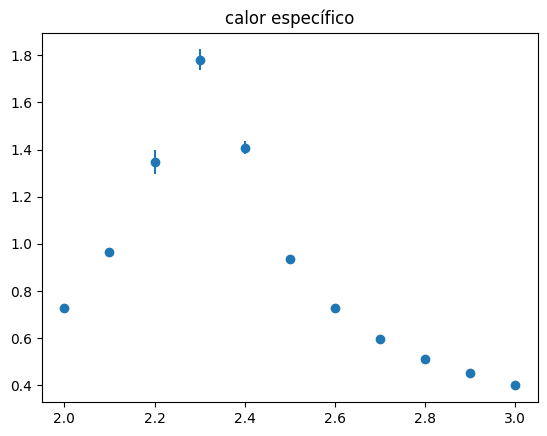

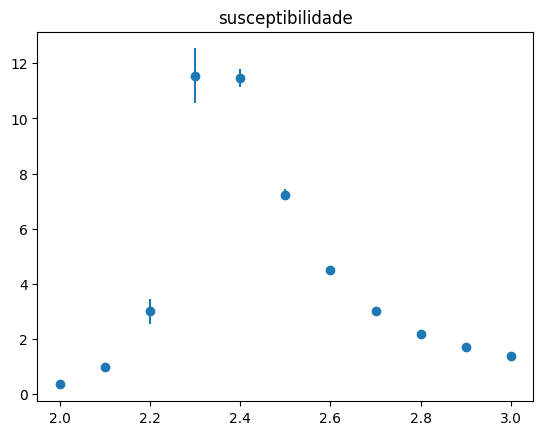

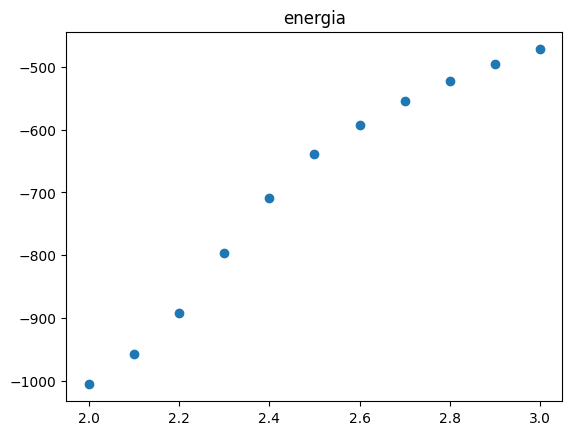

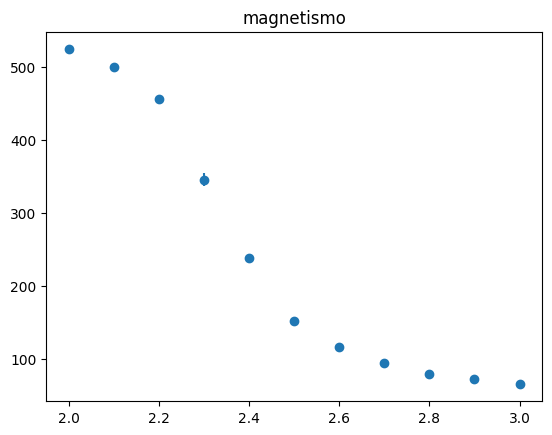

In [21]:
grafico = [(lista_cv, erros_cv, 'calor específico'), (lista_suscep, erros_suscep, 'susceptibilidade'), (lista_energia, erros_energia, 'energia'), (lista_magnetismo, erros_magnetismo, 'magnetismo')]

for grandeza in grafico:
    plt.scatter(temperaturas, grandeza[0])
    plt.errorbar(temperaturas, grandeza[0], yerr=grandeza[1], fmt='none')
    plt.title(grandeza[2])
    plt.plot()
    plt.show()

Com a configuração do tamanho do sistema L = 24 e temperatura variando entre 2.0 e 3.0 observamos que o Calor Específico e a Susceptibilidade Magnética tiveram um comportamento similar, apresentando um pico para temperaturas entre 2.2 e 2.4. Esse mudança abrupta é esperada em fenônemos de transição de fase, o que provavelmente acontece nesse sistema com o aumento da temperatura. Já a Energia, assim como foi observado na atividade anterior, cresceu à medida que a temperatura foi aumentando, uma vez que ocorre um aumento da interação entre as partículas e também de suas energias cinéticas. Por fim, para a Magnetização ocorreu o processo oposto, onde o aumento da temperatura provocou a diminuição da Magnetização, devido a maior agitação das partículas que pertuba suas orientações magnéticas.



### Questão 3

### L = 50

In [22]:
L = 50
temperaturas = [3.0, 2.9,2.8, 2.7,2.6, 2.5, 2.4, 2.3, 2.2, 2.1, 2.0]
erros_cv = []
lista_cv = []
erros_suscep = []
lista_suscep = []
erros_energia = []
lista_energia = []
erros_magnetismo = []
lista_magnetismo = []
s = init_spin(L)

for i in range(len(temperaturas)):
    s, cv_mean, E_mean, M_mean, X_mean, CV_error, E_error, M_error, X_error = simulacao(L, temperaturas[i], s)
    erros_cv.append(CV_error)
    lista_cv.append(cv_mean)
    erros_suscep.append(X_error)
    lista_suscep.append(X_mean)
    erros_energia.append(E_error)
    lista_energia.append(E_mean)
    erros_magnetismo.append(M_error)
    lista_magnetismo.append(M_mean)

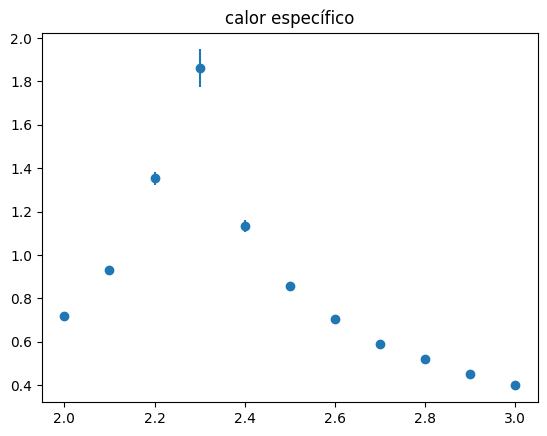

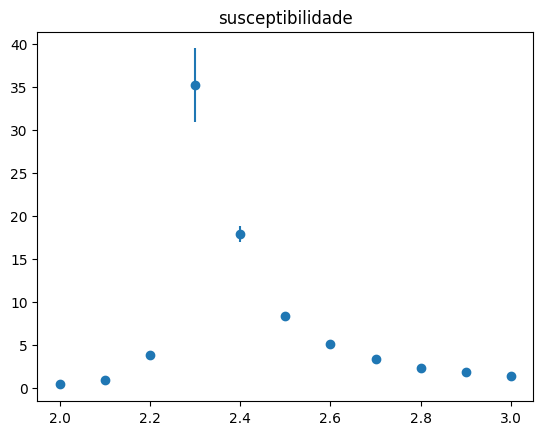

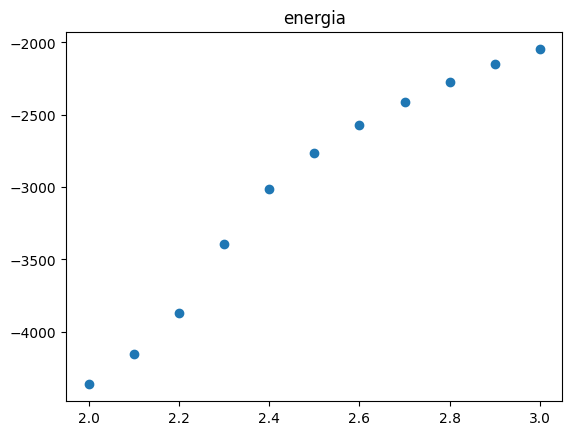

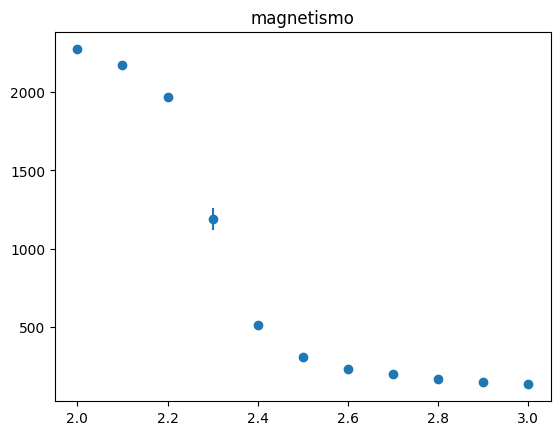

In [23]:
grafico = [(lista_cv, erros_cv, 'calor específico'), (lista_suscep, erros_suscep, 'susceptibilidade'), (lista_energia, erros_energia, 'energia'), (lista_magnetismo, erros_magnetismo, 'magnetismo')]

for grandeza in grafico:
    plt.scatter(temperaturas, grandeza[0])
    plt.errorbar(temperaturas, grandeza[0], yerr=grandeza[1], fmt='none')
    plt.title(grandeza[2])
    plt.plot()
    plt.show()

Para diferentes configurações de L percebemos mudanças nas curvas das grandezas termodinâmicas. Com o aumento do tamanho da rede, ocorreu alteração na posição e na forma dos picos do calor específico e da susceptibilidade magnética com grande aumento das suas magnitudes. A temperatura referente aos picos se manteve em torno de 2.4. Por outro lado, houve maior inclinação das curvas de energia e de magnetização(a magnitude para o intervalo de temperaturas observado aumentou consideravelmente).

### Questão 4

O comportamento dos erros estatísticos pode variar à medida que a temperatura do sistema é alterada. É esperado que os erros estatísticos diminuam com o aumento do número de passos de Monte Carlo, já que mais passos representam um sistema mais estável. A partir da análise dos gráficos, percebe-se o aumento dos erros estatísticos no momento em que o sistema se aproxima da temperatura crítica. Em relação a variação do sistema, a medida que ele aumenta, também ocorrem maiores valores de erros estatísticos.

### Questão 5

É possível que seja uma mudança entre a fase paramagnética para ferromagnética, uma vez que foi observado um pico no calor específico. No estado ferromagnético, os spins dos eletróns estão orientados na mesma direção, ao contrário do estado paramagnético, em que os spins dos eletróns estão orientados de forma aleatória.

### Questão 6

A temperatura crítica no limite termodinâmico estimada foi com base em simulações com tamanhos grandes de sistema, onde a variação entre duas simulações não fosse tão significativa, por exemplo no pico em 2.3.